In [1]:
from sklearn import model_selection, datasets, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boston = datasets.load_boston()
print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
print "feature names: {}".format(boston.feature_names)

feature names: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [4]:
boston_frame = pd.DataFrame(boston.data)
boston_frame.columns = boston.feature_names
boston_frame['target'] = boston.target
boston_frame.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
X, y = boston_frame.iloc[:, :-1], boston_frame.iloc[:, -1]

In [6]:
#X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
# as said - 25% last for test
train_len = int(0.75 * len(X) + 0.5)
X_train, X_test = X.iloc[:train_len], X.iloc[train_len:]
y_train, y_test = y.iloc[:train_len], y.iloc[train_len:]

## Теперь реализуем класс

Так как решается задача регрессии, то будем использовать MSE.

In [7]:
class Tree(object):
    def __init__(self, indices, feature=0, threshold=0.):
        self.indices = np.array(indices)
        self.left, self.right = None, None
        self.feature = feature
        self.threshold = threshold
        
        
def H(R):
    if len(R) == 0:
        return 10.**300
    R = np.array(R)
    mean = R.mean()
    return 1./len(R) * ((R - mean)**2).sum()
        

class DecisionTree(object):
    def __init__(self, max_depth=None):
        self.root = None
        self.max_depth = max_depth
    
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            self.X = X.values
        else:
            self.X = X
        if isinstance(y, pd.DataFrame):
            self.y = y.values
        else:
            self.y = np.array(y)
        indices = range(X.shape[0])
        self.root = Tree(indices)
        self.devide(self.root, 0)
        
    def predict(self, X):
        X = X.values
        y_pred = np.zeros(X.shape[0], dtype='float64')
        for i, x in enumerate(X):
            vertex = self.root
            while vertex.left is not None:
                if x[vertex.feature] < vertex.threshold:
                    vertex = vertex.left
                else:
                    vertex = vertex.right
            y_pred[i] = np.mean(self.y[vertex.indices])
        return y_pred
    
    def devide(self, vertex, depth):
        if vertex is None:
            return
        if self.max_depth is not None and depth == self.max_depth:
            return    
        Q_min = 10.**(300)
        feature_best = 0
        threshold_best = 0.
        indices = vertex.indices
        for j in xrange(self.X.shape[1]):
            feature_j = self.X.T[j]
            for t in sorted(feature_j[indices]):
                left_indices = indices[feature_j[indices] < t]
                right_indices = indices[feature_j[indices] >= t]
                
                left_H = H(self.y[left_indices])
                right_H = H(self.y[right_indices])
                
                Q = 1./len(indices) * (len(left_indices) * left_H + 
                                       len(right_indices) * right_H)
                if Q < Q_min:
                    threshold_best = t
                    feature_best = j
                    Q_min = Q
                    
        vertex.feature = feature_best
        vertex.threshold = threshold_best
        
        left_indices = indices[(self.X.T[feature_best])[indices] < threshold_best]
        right_indices = indices[(self.X.T[feature_best])[indices] >= threshold_best]
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 
        vertex.left = Tree(left_indices)
        vertex.right = Tree(right_indices)
        
        self.devide(vertex.left, depth + 1)
        self.devide(vertex.right, depth + 1)

In [8]:
model = DecisionTree(max_depth=3)
model.fit(X_train, y_train)

In [9]:
y_pred = model.predict(X_test)

In [10]:
print 'depth = 3, MSE =', metrics.mean_squared_error(y_test, y_pred)

depth = 3, MSE = 36.8636037849


In [11]:
model = DecisionTree()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print 'without limitations on depth MSE =', metrics.mean_squared_error(y_test, y_pred)

without limitations on depth MSE = 48.546031746


In [12]:
y_const = [np.mean(y_train)] * len(y_test)
error_const = metrics.mean_squared_error(y_test, y_const)
print 'for constant prediction mean y MSE =', error_const

for constant prediction mean y MSE = 129.991482421


In [13]:
depths = np.arange(1, 20, 1)
errors = []
for depth in depths:
    model = DecisionTree(max_depth=depth)
    model.fit(X_train, y_train)
    errors += [metrics.mean_squared_error(y_test, model.predict(X_test))]

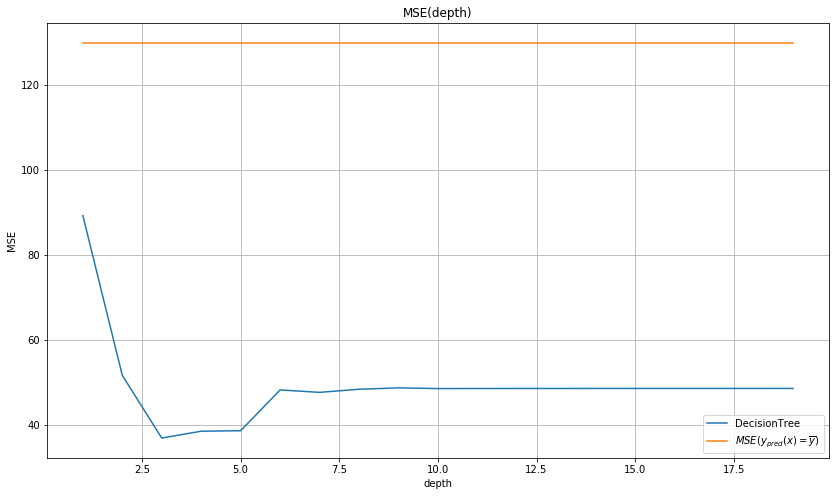

In [14]:
plt.figure(figsize=(14, 8))
plt.title('MSE(depth)')
plt.plot(depths, errors, label='DecisionTree')
plt.plot(depths, [error_const] * len(depths), label='$MSE(y_{pred}(x) = \overline{y})$')
plt.xlabel('depth')
plt.ylabel('MSE')
plt.grid(True)
plt.legend(loc='best')
plt.show()